### 1. IMPORT MODULES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import base64
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from io import BytesIO

from mordred import Calculator, descriptors 

### 2. DATA

In [2]:
df_IDO1_ = pd.read_csv('df_IDO1_clear.csv')
df_IDO1 = df_IDO1_.drop(columns = df_IDO1_.columns[0])
df_IDO1

,ID,SMILES,pIC50,uM,canon_SMILES
0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O
1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O
2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O
3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O
4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O
...,...,...,...,...,...
741,856,CS(=N)(=O)N1CC2(C1)CC(C2)NC3=NON=C3C(=N[C@@H]4...,7.397940,0.0400,CS(=N)(=O)N1CC2(CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F...
742,858,CS(=N)(=O)CCC(CNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.238072,0.0578,CS(=N)(=O)CCC(O)CNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...
743,862,CS(=N)(=O)CC12CC(C1)(C2)NC3=NON=C3C(=N[C@@H]4C...,7.037631,0.0917,CS(=N)(=O)CC12CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F)c...
744,864,CC(CS(=N)(=O)CCNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.245652,0.0568,CC(O)CS(=N)(=O)CCNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...


### 3. Generate Morgan Fingerprints for building model

In [3]:
PandasTools.AddMoleculeColumnToFrame(df_IDO1, 'canon_SMILES', 'Molecule')
def generate_fpts(data):
    Mfpts = []
    for mol in tqdm(data):
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
        Mfpts.append(mfpt)
    return np.array(Mfpts)
mfpts = generate_fpts(df_IDO1.Molecule)

  0%|          | 0/746 [00:00<?, ?it/s][21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPRECATION WARNING: please use MorganGenerator
[21:50:16] DEPREC

In [4]:
# Morgan fingerprints of 746 compounds
morgan = pd.DataFrame(mfpts)
morgan

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
742,0,1,0,1,0,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
743,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
744,0,1,0,1,0,0,1,0,0,0,...,0,1,0,1,0,1,0,0,0,0


### 4. DATA SAMPLING & FEATURE SELECTION

In [5]:
X = morgan
y = df_IDO1.pIC50

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1942001)

#### Feature selection

In [6]:
feature_to_drop = []

In [7]:
#A. Remove highly correlated feature (abs(R)>=0.8)

corr_matrix = X_train.corr().abs()
corr_matrix 
#correlation matrix of 512 features

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.000000,0.123639,0.001369,0.151266,0.015933,0.087276,0.263146,0.009866,0.016978,0.368916,...,0.097386,0.160717,0.066429,0.224550,0.400268,0.174662,0.041692,0.033984,0.048223,0.080939
1,0.123639,1.000000,0.081112,0.033724,0.091287,0.137669,0.129140,0.165919,0.090885,0.047570,...,0.051204,0.144187,0.084031,0.023268,0.031683,0.041784,0.011811,0.007053,0.152026,0.027632
2,0.001369,0.081112,1.000000,0.012291,0.091223,0.034916,0.153452,0.042780,0.037550,0.042704,...,0.048955,0.266082,0.024921,0.041947,0.021112,0.015669,0.015641,0.012749,0.018091,0.030364
3,0.151266,0.033724,0.012291,1.000000,0.069394,0.018098,0.239072,0.308460,0.025167,0.108514,...,0.036056,0.187766,0.039883,0.161117,0.010717,0.479861,0.001641,0.016780,0.053315,0.089485
4,0.015933,0.091287,0.091223,0.069394,1.000000,0.010503,0.001393,0.044549,0.023023,0.047652,...,0.014581,0.073128,0.042523,0.052929,0.008372,0.109917,0.027048,0.060080,0.031286,0.016947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.174662,0.041784,0.015669,0.479861,0.109917,0.229187,0.285472,0.202686,0.051430,0.041986,...,0.123330,0.101369,0.038342,0.028238,0.036761,1.000000,0.041326,0.010732,0.078257,0.092879
508,0.041692,0.011811,0.015641,0.001641,0.027048,0.018299,0.060151,0.016749,0.024415,0.027766,...,0.031831,0.010146,0.091099,0.054657,0.021538,0.041326,1.000000,0.008289,0.011763,0.019743
509,0.033984,0.007053,0.012749,0.016780,0.060080,0.014916,0.063160,0.013653,0.019901,0.022633,...,0.025946,0.028471,0.117989,0.044552,0.017556,0.010732,0.008289,1.000000,0.009588,0.016093
510,0.048223,0.152026,0.018091,0.053315,0.031286,0.021166,0.090837,0.019373,0.028240,0.032116,...,0.013977,0.045596,0.018742,0.003116,0.024912,0.078257,0.011763,0.009588,1.000000,0.054494


In [8]:
# Find features that have abs(R) >= 0.8
up_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
col_corr = [column for column in up_triangle.columns if any(up_triangle[column]>= 0.8)]
col_corr

[25,
 86,
 116,
 180,
 189,
 194,
 202,
 208,
 231,
 266,
 276,
 291,
 298,
 318,
 329,
 337,
 341,
 349,
 358,
 373,
 386,
 391,
 392,
 393,
 396,
 398,
 416,
 425,
 430,
 434,
 436,
 437,
 443,
 457,
 463,
 475,
 506]

In [9]:
for i in range(len(col_corr)):
    feature_to_drop.append(col_corr[i])

In [10]:
#B. Remove low variance feature (var<=0.1)

variances = X_train.var()
variances
# Find features that have var < 0.1
col_var = variances[variances <= 0.1].index
col_var

Index([  2,   4,   5,   7,   8,   9,  10,  11,  12,  14,
       ...
       499, 500, 501, 502, 504, 506, 508, 509, 510, 511],
      dtype='int64', length=402)

In [11]:
for j in range(len(col_var)):
    feature_to_drop.append(col_var[j])

In [12]:
feature_to_drop = list(set(feature_to_drop))
len(feature_to_drop) 
# Number of feature to drop

421

In [13]:
X_train_drop = X_train.drop(columns = feature_to_drop)
X_test_drop = X_test.drop(columns = feature_to_drop)

In [14]:
X_train_drop

,0,1,3,6,13,15,22,32,33,36,...,452,453,468,472,482,486,490,503,505,507
702,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,1
276,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
658,0,0,0,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
288,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
296,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
455,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [15]:
y_train

702    7.619789
276    6.296709
658    7.647817
288    6.301030
467    6.045565
         ...   
466    7.327902
259    5.484789
296    7.229148
455    7.166853
28     6.173925
Name: pIC50, Length: 596, dtype: float64

### 5. MODEL BUILDING

In [16]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [82]:
# Search for best parameter of SVR algorithm
params = {'C': range(1,51,1),
          'epsilon': [1e-3, 1e-2, 1e-1, 0.5, 1],
          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}
model = SVR()
grid = GridSearchCV(model, params, scoring = 'r2', cv = 10, verbose = 2)

grid.fit(X_train_drop, y_train)

best_parameter= grid.best_params_

best_score = grid.best_score_

print(best_parameter)
print(best_score)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, epsilon=

In [33]:
model = SVR(C=2, epsilon=0.1, kernel = 'rbf')
model.fit(X_train_drop, y_train)

y_pred_train = model.predict(X_train_drop)

y_pred_test = model.predict(X_test_drop)

print(f'r2 on training set: {r2_score(y_train, y_pred_train)}')

cross = cross_val_score(model, X_train_drop, y_train, cv = 10)
print(cross)
print(f'q2_score: {cross.mean()}')

print(f'r2 on test set: {r2_score(y_test, y_pred_test)}')

r2 on training set: 0.8809580337032589
[0.69177075 0.62760341 0.29611785 0.48880591 0.7796547  0.71086219
 0.47725842 0.73142939 0.63331953 0.73626328]
q2_score: 0.6173085439006843
r2 on test set: 0.8013061839112816


### 6. GENERATE APPLICABILITY DOMAIN OF ORIGINAL DATA

In [18]:
X_train_drop.shape

(596, 91)

In [19]:
warning_leverage = (3*(91+1))/596
warning_leverage

0.46308724832214765

In [20]:
# Calculate leverage value of training set and test set
X_train_drop_ = X_train_drop.to_numpy()
X_test_drop_ = X_test_drop.to_numpy()

leverage_train = np.diag(X_train_drop_@ np.linalg.inv(X_train_drop_.T @ X_train_drop_) @ X_train_drop_.T)
leverage_test = np.diag(X_test_drop_@ np.linalg.inv(X_train_drop_.T @ X_train_drop_) @ X_test_drop_.T)

In [21]:
Y_train = pd.DataFrame(y_train)
Y_train['pred'] = y_pred_train
Y_train['residual'] = Y_train['pIC50'] - Y_train['pred']
Y_train['squared'] = Y_train['residual']**2
mse_train = Y_train['squared'].sum()/(len(Y_train['squared']))
Y_train['leverage'] = leverage_train
Y_train['standard'] = Y_train['residual']/(mse_train)**0.5

Y_test = pd.DataFrame(y_test)
Y_test['pred'] = y_pred_test
Y_test['residual'] = Y_test['pIC50'] - Y_test['pred']
Y_test['squared'] = Y_test['residual']**2
mse_test = Y_test['squared'].sum()/(len(Y_test['squared']))
Y_test['leverage'] = leverage_test
Y_test['standard'] = Y_test['residual']/(mse_test)**0.5

print(Y_train)
print(Y_test)

        pIC50      pred  residual   squared  leverage  standard
702  7.619789  7.297620  0.322169  0.103793  0.089839  1.148165
276  6.296709  6.234525  0.062184  0.003867  0.107277  0.221614
658  7.647817  7.523718  0.124099  0.015401  0.097351  0.442271
288  6.301030  6.401377 -0.100347  0.010069  0.118964 -0.357621
467  6.045565  6.145406 -0.099842  0.009968  0.208275 -0.355821
..        ...       ...       ...       ...       ...       ...
466  7.327902  7.227659  0.100243  0.010049  0.169840  0.357251
259  5.484789  5.601222 -0.116434  0.013557  0.091643 -0.414953
296  7.229148  7.128803  0.100345  0.010069  0.123682  0.357615
455  7.166853  7.120220  0.046633  0.002175  0.337468  0.166193
28   6.173925  6.074055  0.099870  0.009974  0.217444  0.355923

[596 rows x 6 columns]
        pIC50      pred  residual   squared  leverage  standard
108  5.531653  5.676686 -0.145034  0.021035  0.305313 -0.425739
170  7.397940  7.595603 -0.197663  0.039071  0.296097 -0.580229
688  7.168770  6

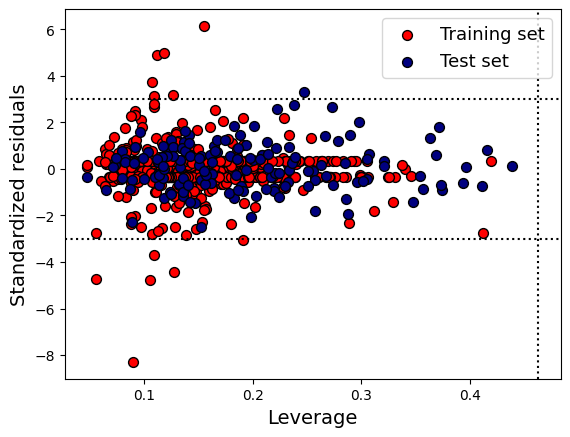

In [22]:
# Applicability domain of model

plt.scatter(Y_train['leverage'], Y_train['standard'], color='red', label='Training set', marker='o', s=50, edgecolors='black')
plt.scatter(Y_test['leverage'], Y_test['standard'], color='navy', label='Test set', marker='o', s=50, edgecolors='black')
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.axvline(x = warning_leverage, color='black', linestyle='dotted')
plt.xlabel('Leverage', fontsize=14)
plt.ylabel('Standardized residuals', fontsize=14)
legend = plt.legend( loc='upper right', fontsize=13)

### 7. OUTLIER DETECTION

In [23]:
elements = []
elements1 = []

for i, element in enumerate(Y_train['leverage']):
    if element > warning_leverage or element < 0:
        elements.append(element)

for j, element1 in enumerate(Y_train['standard']):
    if element1 >= 3 or element1 <= -3 :
        elements1.append(element1)

a = Y_train[Y_train.leverage.isin(elements)]
b = Y_train[Y_train.standard.isin(elements1)]

outlier_train = pd.concat([a,b], axis = 0)
outlier_train = outlier_train.drop_duplicates()
outlier_train

,pIC50,pred,residual,squared,leverage,standard
408,6.480172,5.604724,0.875448,0.766409,0.109180,3.119971
675,5.108518,5.967822,-0.859304,0.738403,0.190961,-3.062435
92,6.954677,5.909198,1.045479,1.093026,0.107402,3.725936
93,7.161151,5.785041,1.376110,1.893678,0.111633,4.904259
695,4.969805,7.297620,-2.327814,5.418720,0.089839,-8.295997
507,5.571703,6.916680,-1.344977,1.808962,0.104849,-4.793304
343,7.337242,5.937545,1.399698,1.959153,0.118294,4.988322
176,7.221849,5.497546,1.724303,2.973220,0.154520,6.145168
81,6.787812,5.896682,0.891130,0.794113,0.126347,3.175861
293,4.602060,5.842630,-1.240570,1.539015,0.127051,-4.421215


In [24]:
outlier_train.index

Index([408, 675, 92, 93, 695, 507, 343, 176, 81, 293, 57, 428], dtype='int64')

### 8. EVALUATION WITH FINAL DATABASE

In [25]:
X_train_new = X_train_drop.drop(outlier_train.index)
y_train_new = y_train.drop(outlier_train.index)

In [32]:
# Search for best parameter of SVR algorithm
params = {'C': range(1,51,1),
          'epsilon': [1e-3, 1e-2, 1e-1, 0.5, 1],
          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}
model = SVR()
grid = GridSearchCV(model, params, scoring = 'r2', cv = 10, verbose = 2)

grid.fit(X_train_new, y_train_new)

best_parameter= grid.best_params_

best_score = grid.best_score_

print(best_parameter)
print(best_score)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, epsilon=

In [34]:
model = SVR(C=3, epsilon=0.1, kernel = 'rbf')
model.fit(X_train_new, y_train_new)

y_pred_train_new = model.predict(X_train_new)

y_pred_test_new = model.predict(X_test_drop)

print(f'r2 on training set: {r2_score(y_train_new, y_pred_train_new)}')

cross = cross_val_score(model, X_train_new, y_train_new, cv = 10)
print(cross)
print(f'q2_score: {cross.mean()}')

print(f'r2 on test set: {r2_score(y_test, y_pred_test_new)}')

r2 on training set: 0.9523134554245
[0.72218888 0.7266494  0.58753667 0.73242808 0.76713803 0.72044857
 0.56021623 0.77654757 0.62086943 0.75067891]
q2_score: 0.6964701785588872
r2 on test set: 0.7953520679363525


#### Application domain of final database

In [27]:
X_train_new.shape

(584, 91)

In [28]:
warning_leverage = (3*(91+1))/584
warning_leverage

0.4726027397260274

In [29]:
# Calculate leverage value of new training set and test set
X_train_new_ = X_train_new.to_numpy()
X_test_drop_ = X_test_drop.to_numpy()

leverage_train_new = np.diag(X_train_new_@ np.linalg.inv(X_train_new_.T @ X_train_new_) @ X_train_new_.T)
leverage_test_new = np.diag(X_test_drop_@ np.linalg.inv(X_train_new_.T @ X_train_new_) @ X_test_drop_.T)

In [30]:
Y_train_new = pd.DataFrame(y_train_new)
Y_train_new['pred'] = y_pred_train_new
Y_train_new['residual'] = Y_train_new['pIC50'] - Y_train_new['pred']
Y_train_new['squared'] = Y_train_new['residual']**2
mse_train_new = Y_train_new['squared'].sum()/(len(Y_train_new['squared']))
Y_train_new['leverage'] = leverage_train_new
Y_train_new['standard'] = Y_train_new['residual']/(mse_train_new)**0.5

Y_test_new = pd.DataFrame(y_test)
Y_test_new['pred'] = y_pred_test_new
Y_test_new['residual'] = Y_test_new['pIC50'] - Y_test_new['pred']
Y_test_new['squared'] = Y_test_new['residual']**2
mse_test_new = Y_test_new['squared'].sum()/(len(Y_test_new['squared']))
Y_test_new['leverage'] = leverage_test_new
Y_test_new['standard'] = Y_test_new['residual']/(mse_test_new)**0.5

print(Y_train_new)
print(Y_test_new)

        pIC50      pred  residual   squared  leverage  standard
702  7.619789  7.520156  0.099633  0.009927  0.099288  0.567714
276  6.296709  6.196682  0.100027  0.010005  0.111985  0.569957
658  7.647817  7.547598  0.100219  0.010044  0.098033  0.571055
288  6.301030  6.401359 -0.100329  0.010066  0.130219 -0.571681
467  6.045565  6.145872 -0.100307  0.010062  0.209587 -0.571556
..        ...       ...       ...       ...       ...       ...
466  7.327902  7.228056  0.099846  0.009969  0.171749  0.568927
259  5.484789  5.584654 -0.099865  0.009973  0.092700 -0.569038
296  7.229148  7.129250  0.099898  0.009980  0.129148  0.569225
455  7.166853  7.112978  0.053875  0.002903  0.338507  0.306984
28   6.173925  6.073993  0.099932  0.009986  0.218545  0.569419

[584 rows x 6 columns]
        pIC50      pred  residual       squared  leverage  standard
108  5.531653  5.670988 -0.139335  1.941434e-02  0.308074 -0.403018
170  7.397940  7.638522 -0.240582  5.787961e-02  0.297574 -0.695867
688 

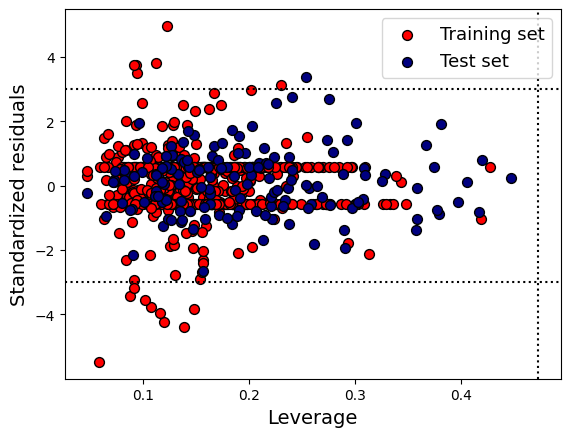

In [31]:
# Applicability domain of final model

plt.scatter(Y_train_new['leverage'], Y_train_new['standard'], color='red', label='Training set', marker='o', s=50, edgecolors='black')
plt.scatter(Y_test_new['leverage'], Y_test_new['standard'], color='navy', label='Test set', marker='o', s=50, edgecolors='black')
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.axvline(x = warning_leverage, color='black', linestyle='dotted')
plt.xlabel('Leverage', fontsize=14)
plt.ylabel('Standardized residuals', fontsize=14)
legend = plt.legend( loc='upper right', fontsize=13)